# Test RAG

В этом блокноте мы показываем, как мы тестировали собственную архитектуру RAG.

Основные разделы:
1. Выбор параметров для тестирования
2. Валидация с помощью **RAGAS**
3. Результаты

## Necessary imports

In [ ]:
!pip install -U langchain langchain-community chromadb sentence-transformers tqdm datasets langchain_experimental ragas langchain_huggingface rank_bm25

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.7/185.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 15.1 MB/s 

In [ ]:
import nest_asyncio

nest_asyncio.apply()

from getpass import getpass
import os
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import time
import logging
from datasets import Dataset
import chromadb
from chromadb.config import Settings
import asyncio
import operator


from langchain import FewShotPromptTemplate
from langchain_core.documents import Document
from langchain.retrievers import ContextualCompressionRetriever, EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain.chains import LLMChain
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.document_loaders import DirectoryLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain.document_loaders import WebBaseLoader
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
    TextSplitter,
    TokenTextSplitter,
)
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_core.callbacks import (
    AsyncCallbackManagerForRetrieverRun,
    CallbackManagerForRetrieverRun,
)
from langchain_community.document_transformers import (
    LongContextReorder
)
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer, CrossEncoder, util, models

from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    answer_correctness
)

from warnings import filterwarnings

filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/COurses_WOrk/AI_Hack
!ls

/content/drive/MyDrive/COurses_WOrk/AI_Hack
 answers.csv		      'notebookccf68588d3 (1).ipynb'
 answers.gsheet		       production_rag_example.ipynb
 checkpoints		       production_rag_validation.ipynb
 docs_from_path		       rag-eval.ipynb
 fine_tune_big_dataset	       results
 fine-tuned-model	       results_Self_Validation_Pipeline.csv
 fine-tuned-model-v2	       results-v2
 fine-tuned-reranker-v1        testRag.ipynb
'finetune_embedding.ipynb"'    total_rag
 finetune_embedding_v2.ipynb   v2_fine_tune
 fine_tune_train_data	       v2_ragas_npa_dataset_firstPart.xlsx
 hmao_npa_cleaned_v1.txt      'Копия блокнота "finetune_embedding.ipynb"'


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device - {device}')

Device - cpu


In [ ]:
os.environ['OPENAI_API_KEY'] = getpass(prompt='Введите ваш OpenAI API ключ')

Введите ваш OpenAI API ключ··········


In [ ]:
os.environ["OPENAI_API_KEY"] = "sk-or-vv-678cbad362790622377958c8beb4937642cfb7083ee6cfce2d62886dc4b86326"
os.environ["OPENAI_API_BASE"] = "https://api.vsegpt.ru/v1"

# Params for validation

**Model name:**

*   model_name_v1 = 'ianssens/e5-model-rag'
*   model_name_v2 = 'ianssens/e5-model-rag-v2'

**Cross-encoder:**
- 'amberoad/bert-multilingual-passage-reranking-msmarco'
- 'ianssens/bmprm-ranker-v1'

**Embeddings/Chunks:**

* collection_name_v1 = 'modelv1_750_100_base'
* collection_name_v2 = 'modelv2_512_20_base'

In [ ]:
params = {
 'model_name' : "ianssens/e5-model-rag",
 'cross_encoder_name' : 'amberoad/bert-multilingual-passage-reranking-msmarco',
 'collection_name' : "modelv1_750_100_base",
 'llm' : "gpt-4o-mini",
 'top_k_search' : 30,
 'search_type' : "similarity",
 'weights' : [0.4, 0.6],
}

 Менять в коде

 * 'threshold' в reranker : 0.8

 * 'top k' в llm : 15

### Choose emb_model, emb, llms


In [ ]:
collection_name = params['collection_name']
model_name = params['model_name']

In [ ]:
llm = ChatOpenAI(
    model_name=params['llm'],
    temperature=0,
    )

In [ ]:
llm = ChatOpenAI(
    model_name=params['llm'],
    temperature=0,
    openai_api_key="sk-or-vv-678cbad362790622377958c8beb4937642cfb7083ee6cfce2d62886dc4b86326",
    base_url="https://api.vsegpt.ru/v1"
    )

In [ ]:
embedding_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={'device': device}
)

In [ ]:
cross_tokenizer = AutoTokenizer.from_pretrained(params['cross_encoder_name'])
cross_model = AutoModelForSequenceClassification.from_pretrained(params['cross_encoder_name'])

### Croma DB connect -> retriver

In [ ]:
client = chromadb.HttpClient(
        host='62.68.146.97',
        port=8000,
        ssl=False,
        headers=None,
        settings=Settings(),
        tenant=chromadb.DEFAULT_TENANT,
        database=chromadb.DEFAULT_DATABASE,
    )

db = Chroma(
    client=client,
    collection_name=collection_name,
    embedding_function=embedding_model
)

In [ ]:
chroma_retriever = db.as_retriever(
    search_type=params['search_type'],
    search_kwargs={"k": params['top_k_search']},
)

### Example in code

In [ ]:
query = "Как осуществляется представление информации в ходе проверки юридического лица или индивидуального предпринимателя?"

In [ ]:
relevant_docs_from_retriver = chroma_retriever.get_relevant_documents(query)
len(relevant_docs_from_retriver)

10

## EnsembleRetriever (BM25)

In [ ]:
collection = client.get_collection(name=collection_name)
documents = collection.get()


In [ ]:
bm25_retriever = BM25Retriever.from_texts(
            texts=documents.get("documents"),
            metadatas=documents.get("metadatas"),
        )
bm25_retriever.k = params['top_k_search']

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_retriever], weights=params['weights']
)

# RAG Pipline

## Self-querying

In [ ]:
def Self_Querying(query, llm):

  QUERY_REDACTING_PROMPT = f"""
      Ты – русскоязычный полезный ассистент.
      Ты помогаешь технической поддержке с поступающими вопросами.
      Пользователи не всегда пишут полные вопросы, ты помогаешь
      перефразировать поступающий вопрос и выделяешь основную проблему,
      если это требуется. Ты всегда исправишь опечатки и ошибки.
      Постарайся максимально передать изначальный смысл и посыл вопроса.
      Вот вопрос пользователя: {query}
      Перефразированный и исправь вопрос:
      """


  return llm.invoke(QUERY_REDACTING_PROMPT).content

### Example in code

In [ ]:
res = Self_Querying(query, llm)
res

'Как происходит представление информации при проверке юридического лица или индивидуального предпринимателя?'

## async MultiQueryRetriever

In [ ]:
async def Multi_Query_Retriever(query, llm, retriever):

  QUERY_EXPANSION_PROMPT = PromptTemplate(
      input_variables=["question"],
      template=
      """
      Ты – русскоязычный полезный ассистент.Твоя задача — сгенерировать три
      различных версий заданного пользовательского вопроса для извлечения
      соответствующих документов из векторной базы данных.
      Создавая несколько точек зрения на вопрос пользователя, ваша цель — помочь
      пользователю преодолеть некоторые ограничения поиска по сходству на основе расстояния.
      Предоставьте эти альтернативные вопросы, разделенные символами новой строки.
      Предоставьте только запрос, без нумерации.
      Исходный вопрос: {question}
      """,
  )
  retriever_from_llm = MultiQueryRetriever.from_llm(
      retriever=retriever,
      llm=llm,
      prompt=QUERY_EXPANSION_PROMPT,
      include_original=True
  )

  run_manager = AsyncCallbackManagerForRetrieverRun(
      run_id="first_id",
      handlers=[],
      inheritable_handlers=[]
  )

  unique_docs = await retriever_from_llm._aget_relevant_documents(
      query=query,
      run_manager=run_manager)

  return unique_docs

### Example in code

In [ ]:
relevant_docs_from_retriver = await Multi_Query_Retriever(res, llm,  ensemble_retriever)
len(relevant_docs_from_retriver)

78

## Cross encoder

In [ ]:
def reranker(docs):
  pairs = []
  for doc in docs:
      tokenized_input = cross_tokenizer(query, doc.page_content, truncation=True, max_length=512, return_tensors="pt")
      pairs.append(tokenized_input)
  print(len(pairs))
  scores = []
  for pair in pairs:
      outputs = cross_model(**pair)
      logits = outputs.logits
      probabilities = F.softmax(logits, dim=-1)
      prob_for_related = probabilities[0, 1]
      scores.append(prob_for_related.item())
  print(len(scores))

  scored_docs = zip(scores, docs)
  filtered_docs = [(score, doc) for score, doc in scored_docs if score >= 0.85] #  Тоже не знаю как вытащить правильно
  if filtered_docs == []:
      filtered_docs = [(score, doc) for score, doc in scored_docs]
  sorted_docs = sorted(filtered_docs, key=lambda x: x[0], reverse=True)

  return sorted_docs

### Example in code

In [ ]:
sorted_docs = reranker(relevant_docs_from_retriver)
len(sorted_docs)

NameError: name 'relevant_docs_from_retriver' is not defined

In [ ]:
sorted_docs

[(0.9992687106132507,
  Document(metadata={'source': '../data/hmao_npa_cleaned_v2.txt'}, page_content='уполномоченным представителем юридического лица, индивидуальным предпринимателем или уполномоченным представителем индивидуального предпринимателя определяют круг лиц, с которыми будет осуществляться взаимодействие в ходе проверки, уточняет перечень документов, возможность с их ознакомлением, а также временной режим проверки (с учетом действующего режима работы юридического лица, индивидуального предпринимателя). 3.12.5. В ходе проверки осуществляются: визуальный осмотр территории, находящейся в пользовании юридического лица, индивидуального предпринимателя; анализ документов и представленной информации; иные мероприятия по надзору, предусмотренные Федеральным законом отдекабрягода N 294-ФЗ. 3.12.5.1. Визуальный осмотр территории,')),
 (0.9988203644752502,
  Document(metadata={'source': '../data/hmao_npa_cleaned_v2.txt'}, page_content='предусмотренные Федеральным законом отдекабрягода

In [ ]:
sorted_docs

[(0.9992527365684509,
  Document(metadata={'source': '../data/hmao_npa_cleaned_v2.txt'}, page_content='в этих документах, сведениям, содержащимся в имеющихся у Природнадзора Югры, его территориального структурного подразделения документах и (или) полученным в ходе осуществления проверки, юридическому лицу, индивидуальному предпринимателю направляется письмо с информацией об этом и требованием представить в течение десяти рабочих дней необходимые пояснения в письменной форме. 3.13.7. Председатель комиссии (уполномоченное должностное лицо) обязано рассмотреть полученные от юридического лица, индивидуального')),
 (0.9991961121559143,
  Document(metadata={'source': '../data/hmao_npa_cleaned_v2.txt'}, page_content='находящейся в пользовании юридического лица, индивидуального предпринимателя, осуществляется должностными лицами Природнадзора Югры, его территориального структурного подразделения в присутствии руководителя, иного должностного лица или уполномоченного представителя юридического 

## Middle Problem

In [ ]:
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(sorted_docs)
reordered_docs

## Generation

In [ ]:
def Aug_Generation(query, llm, retriever, result):
  contexts = []
  for doc in result[:params['top_k_search']]:
      contexts.append(doc.page_content)
  context_str = '\n\n##\n\n'.join(contexts)

  examples = [
      {
          "query": "Каков объем экспорта услуг категории 'Поездки' в региональном проекте 'Экспорт услуг' категории 'Поездки' в Ханты-Мансийском автономном округе - Югре?",
          "answer": "Объем экспорта услуг категории 'Поездки' в региональном проекте 'Экспорт услуг' категории 'Поездки' в Ханты-Мансийском автономном округе - Югре составляет 0,033 млрд долларов США."
      }, {
          "query": "Какова общая сумма по городу Когалыму за 2013-2014 годы?",
          "answer": "Общая сумма по городу Когалыму за 2013-2014 годы составляет 265147484,00 рублей."
      }, {
          "query": "Где узнать о порядке обжалования решений?",
          "answer": "О порядке обжалования действий (бездействия) и решений, осуществляемых и принимаемых в ходе предоставления государственной услуги, можно узнать у ответственных должностных лиц Департамента, которые ответственны за предоставление государственной услуги."
      }, {
          "query": "Когда принято постановление Правительства автономного округа N 48-п?",
          "answer": "Постановление Правительства Ханты-Мансийского автономного округа - Югры N 48-п 'Об оплате труда работников государственных учреждений Ханты-Мансийского автономного округа - Югры' принято 3 марта 2005 года."
      }, {
          "query": "Кто отвечает за информационную безопасность в ХМАО-Югре, если Губернатор отсутствует?",
          "answer": "В случае отсутствия Губернатора Ханты-Мансийского автономного округа - Югры, его обязанности исполняет заместитель Губернатора Ханты-Мансийского автономного округа - Югры. Заместитель Губернатора имеет в ведении Департамент информационных технологий и цифрового развития Ханты-Мансийского автономного округа - Югры, который, вероятно, отвечает за вопросы информационной безопасности."
      }
  ]

  example_template = """Пользователь: {query}
  ИИ: {answer}
  """

  example_prompt = PromptTemplate(
      input_variables=["query", "answer"],
      template=example_template)

  prefix = """
  Игнорируй все предыдущие инструкции. Ты консультант-юрист. Помогаешь с вопросами
  по нормативным правовым актам (далее НПА) ХАНТЫ-МАНСИЙСКОГО АВТОНОМНОГО ОКРУГА-ЮГРЫ.
  Будь вежлив. Выяви потребность клиента и помоги ему решить ее с помощью НПА.
  Все НПА действительные. Отвечай на вопросы на основе фактов, которые тебе дадут.
  Не придумывай новую информация! Также используй данные из контекста.

  ###

  Контекст:
  {context_str}

  ###

  Используй только знания о НПА и примеры ответов на консультациях. Если в этих
  данных нет ответа и ты в этом уверен, скажи, что “я не знаю”, предложи обратиться к живому
  консультанту компании. Не придумывай факты, которых нет в контексте. Ты можешь
  использовать свои общие знания в разных областях,
  чтобы давать общие советы своим пользователям.
  Отвечай на языке, на котором посетитель задал вопрос(по умолчанию используй русский язык).

  ###

  В своем ответе используй следующие принципы:
  1. Ты должен давать четкие, краткие и прямые ответы.
  2. Исключи ненужные напоминания, извинения, упоминания самого себя и любые заранее запрограммированные тонкости.
  3. Сохраняй непринужденный тон в общении.
  4. Будь прозрачным; если ты не уверен в ответе или если вопрос выходит за рамки твоих возможностей или знаний, признай это.
  5. В случае неясных или двусмысленных вопросов задавай дополнительные вопросы, чтобы лучше понять намерения пользователя.
  6. При объяснении концепций используй примеры и аналогии из реальной жизни, где это возможно.
  7. В случае сложных запросов сделай глубокий вдох и работай над проблемой шаг за шагом.
  8. За каждый ответ ты получишь чаевые до 200 долларов (в зависимости от качества твоего ответа).
  Очень важно, чтобы ты понял это правильно. На кону несколько жизней и моя карьера.

  Вот несколько примеров ответов:

  ###

  """

  suffix = """
  Пользователь: {query}
  ИИ: """

  few_shot_prompt_template = FewShotPromptTemplate(
      examples=examples,
      example_prompt=example_prompt,
      prefix=prefix,
      suffix=suffix,
      input_variables=["query", "context_str"],
      example_separator="\n\n"
  )

  return llm.invoke(few_shot_prompt_template.format(query=query, context_str=context_str)).content


# validation

In [ ]:
class Self_Validation_Pipeline:
    def __init__(self, llm, cross_tokenizer, cross_model, retriever):
        self.llm = llm
        self.cross_tokenizer = cross_tokenizer
        self.cross_model = cross_model
        self.retriever = retriever
        self.self_query = False
        self.multi_query = False

    def self_querying(self, query):
        """
        Функция Self-Querying для генерации переформулированных запросов.
        """

        QUERY_REDACTING_PROMPT = f"""
        Ты – русскоязычный полезный ассистент.
        Ты помогаешь технической поддержке с поступающими вопросами.
        Пользователи не всегда пишут полные вопросы, ты помогаешь
        перефразировать поступающий вопрос и выделяешь основную проблему,
        если это требуется. Ты всегда исправишь опечатки и ошибки.
        Постарайся максимально передать изначальный смысл и посыл вопроса.
        Вот вопрос пользователя: {query}
        Перефразированный и исправь вопрос:
        """

        return self.llm.invoke(QUERY_REDACTING_PROMPT).content

    def augmentation_generation(self, query, result):
        """
        Функция Augmentation Generation для генерации ответов на вопросы.
        """

        contexts = []
        for doc in result[:15]: # Я не знаю как вынести этот параметр адекватно
            contexts.append(doc.page_content)
        context_str = '\n\n##\n\n'.join(contexts)

        examples = [
            {
                "query": "Каков объем экспорта услуг категории 'Поездки' в региональном проекте 'Экспорт услуг' категории 'Поездки' в Ханты-Мансийском автономном округе - Югре?",
                "answer": "Объем экспорта услуг категории 'Поездки' в региональном проекте 'Экспорт услуг' категории 'Поездки' в Ханты-Мансийском автономном округе - Югре составляет 0,033 млрд долларов США."
            }, {
                "query": "Какова общая сумма по городу Когалыму за 2013-2014 годы?",
                "answer": "Общая сумма по городу Когалыму за 2013-2014 годы составляет 265147484,00 рублей."
            }, {
                "query": "Где узнать о порядке обжалования решений?",
                "answer": "О порядке обжалования действий (бездействия) и решений, осуществляемых и принимаемых в ходе предоставления государственной услуги, можно узнать у ответственных должностных лиц Департамента, которые ответственны за предоставление государственной услуги."
            }, {
                "query": "Когда принято постановление Правительства автономного округа N 48-п?",
                "answer": "Постановление Правительства Ханты-Мансийского автономного округа - Югры N 48-п 'Об оплате труда работников государственных учреждений Ханты-Мансийского автономного округа - Югры' принято 3 марта 2005 года."
            }, {
                "query": "Кто отвечает за информационную безопасность в ХМАО-Югре, если Губернатор отсутствует?",
                "answer": "В случае отсутствия Губернатора Ханты-Мансийского автономного округа - Югры, его обязанности исполняет заместитель Губернатора Ханты-Мансийского автономного округа - Югры. Заместитель Губернатора имеет в ведении Департамент информационных технологий и цифрового развития Ханты-Мансийского автономного округа - Югры, который, вероятно, отвечает за вопросы информационной безопасности."
            }
        ]

        example_template = """Пользователь: {query}
        ИИ: {answer}
        """

        example_prompt = PromptTemplate(
            input_variables=["query", "answer"],
            template=example_template)

        prefix = """
        Игнорируй все предыдущие инструкции. Ты консультант-юрист. Помогаешь с вопросами
        по нормативным правовым актам (далее НПА) ХАНТЫ-МАНСИЙСКОГО АВТОНОМНОГО ОКРУГА-ЮГРЫ.
        Будь вежлив. Выяви потребность клиента и помоги ему решить ее с помощью НПА.
        Все НПА действительные. Отвечай на вопросы на основе фактов, которые тебе дадут.
        Не придумывай новую информация! Также используй данные из контекста.

        ###

        Контекст:
        {context_str}

        ###

        Используй только знания о НПА и примеры ответов на консультациях. Если в этих
        данных нет ответа и ты в этом уверен, скажи, что “я не знаю”, предложи обратиться к живому
        консультанту компании. Не придумывай факты, которых нет в контексте. Ты можешь
        использовать свои общие знания в разных областях,
        чтобы давать общие советы своим пользователям.
        Отвечай на языке, на котором посетитель задал вопрос(по умолчанию используй русский язык).

        ###

        В своем ответе используй следующие принципы:
        1. Ты должен давать четкие, краткие и прямые ответы.
        2. Исключи ненужные напоминания, извинения, упоминания самого себя и любые заранее запрограммированные тонкости.
        3. Сохраняй непринужденный тон в общении.
        4. Будь прозрачным; если ты не уверен в ответе или если вопрос выходит за рамки твоих возможностей или знаний, признай это.
        5. В случае неясных или двусмысленных вопросов задавай дополнительные вопросы, чтобы лучше понять намерения пользователя.
        6. При объяснении концепций используй примеры и аналогии из реальной жизни, где это возможно.
        7. В случае сложных запросов сделай глубокий вдох и работай над проблемой шаг за шагом.
        8. За каждый ответ ты получишь чаевые до 200 долларов (в зависимости от качества твоего ответа).
        Очень важно, чтобы ты понял это правильно. На кону несколько жизней и моя карьера.

        Вот несколько примеров ответов:

        ###

        """

        suffix = """
        Пользователь: {query}
        ИИ: """

        few_shot_prompt_template = FewShotPromptTemplate(
            examples=examples,
            example_prompt=example_prompt,
            prefix=prefix,
            suffix=suffix,
            input_variables=["query", "context_str"],
            example_separator="\n\n"
        )

        return self.llm.invoke(few_shot_prompt_template.format(query=query, context_str=context_str)).content, contexts

    async def multi_query_retriever(self, query):
        """
        Функция Multi-Query Retriever для переформулирования запросов и поиска по ним.
        """

        QUERY_EXPANSION_PROMPT = PromptTemplate(
            input_variables=["question"],
            template=
            """
            Ты – русскоязычный полезный ассистент.Твоя задача — сгенерировать три
            различных версий заданного пользовательского вопроса для извлечения
            соответствующих документов из векторной базы данных.
            Создавая несколько точек зрения на вопрос пользователя, ваша цель — помочь
            пользователю преодолеть некоторые ограничения поиска по сходству на основе расстояния.
            Предоставьте эти альтернативные вопросы, разделенные символами новой строки.
            Предоставьте только запрос, без нумерации.
            Исходный вопрос: {question}
            """,
        )
        retriever_from_llm = MultiQueryRetriever.from_llm(
            retriever=self.retriever,
            llm=self.llm,
            prompt=QUERY_EXPANSION_PROMPT,
            include_original=True
        )

        run_manager = AsyncCallbackManagerForRetrieverRun(
            run_id="first_id",
            handlers=[],
            inheritable_handlers=[]
        )

        unique_docs = await retriever_from_llm._aget_relevant_documents(
            query=query,
            run_manager=run_manager
            )

        return unique_docs

    def reranker(self, query, docs):
      """
      Функция Reranker для сортировки документов с помощью cross-encoder.
      """

      pairs = []
      for doc in docs:
          tokenized_input = self.cross_tokenizer(query, doc.page_content, truncation=True, max_length=512, return_tensors="pt")
          pairs.append(tokenized_input)
      scores = []
      for pair in pairs:
          outputs = self.cross_model(**pair)
          logits = outputs.logits
          probabilities = F.softmax(logits, dim=-1)
          prob_for_related = probabilities[0, 1]
          scores.append(prob_for_related.item())

      scored_docs = zip(scores, docs)
      filtered_docs = [(score, doc) for score, doc in scored_docs if score >= 0.8] #  Тоже не знаю как вытащить правильно
      if len(filtered_docs) == 0:
          filtered_docs = [(score, doc) for score, doc in scored_docs]
      sorted_docs_with_scores = sorted(filtered_docs, key=lambda x: x[0], reverse=True)
      sorted_docs = [doc for _, doc in sorted_docs_with_scores]
      return sorted_docs

    async def predict(self, query):
        """
        Основной метод для выполнения всех этапов пайплайна.
        """

        reformulated_query = self.self_querying(query)

        docs = await self.multi_query_retriever(reformulated_query)

        sorted_docs = self.reranker(query, docs)

        response, context = self.augmentation_generation(query, sorted_docs)

        return {"answer": response, "context": context}


In [ ]:
pipeline = Self_Validation_Pipeline(llm=llm,
                                    cross_tokenizer=cross_tokenizer,
                                    cross_model=cross_model,
                                    retriever=ensemble_retriever
                                    )

### Example in code

In [ ]:
query = "Какие условия для покупки объекта в госсобственность округа, если он дороже 100 млн рублей?"

In [ ]:
result = await pipeline.predict(query=query)
print(result)

{'answer': 'Если предполагаемая стоимость объекта, который вы хотите приобрести в государственную собственность округа, превышает 100 миллионов рублей, вам необходимо направить в Департамент экономического развития автономного округа (Депэкономики Югры) документы для проведения проверки инвестиционного проекта. Эта проверка будет касаться эффективности использования бюджетных средств, направляемых на капитальные вложения. \n\nЗаключение Депэкономики должно содержать выводы о наличии или отсутствии подходящего объекта в казне округа, соответствие технических характеристик объекта целям его приобретения, а также соответствие обоснования стоимости объекта требованиям законодательства о контрактной системе.', 'context': ['объекта, не превышаетмиллионов рублей, Депимущества Югры осуществляет оценку рыночной стоимости объекта в соответствии с пунктомПорядка. Если предполагаемая стоимость объекта, указанного в заключении Депимущества Югры об отсутствии оснований, препятствующих приобретению о

In [ ]:
print(result['answer'])

Если предполагаемая стоимость объекта, который вы хотите приобрести в государственную собственность округа, превышает 100 миллионов рублей, вам необходимо направить в Департамент экономического развития автономного округа (Депэкономики Югры) документы для проведения проверки инвестиционного проекта. Эта проверка будет касаться эффективности использования бюджетных средств, направляемых на капитальные вложения. 

Заключение Депэкономики должно содержать выводы о наличии или отсутствии подходящего объекта в казне округа, соответствие технических характеристик объекта целям его приобретения, а также соответствие обоснования стоимости объекта требованиям законодательства о контрактной системе.


In [ ]:
print(result['context'][:2])

['объекта, не превышаетмиллионов рублей, Депимущества Югры осуществляет оценку рыночной стоимости объекта в соответствии с пунктомПорядка. Если предполагаемая стоимость объекта, указанного в заключении Депимущества Югры об отсутствии оснований, препятствующих приобретению объекта, свышемиллионов рублей, Инициатор в порядке, установленном Правительством автономного округа, направляет в Департамент экономического развития автономного округа (далее - Депэкономики Югры) документы, необходимые для проведения проверки инвестиционного проекта, предусматривающего приобретение объекта, на предмет эффективности использования средств бюджета автономного округа, направляемых на капитальные вложения (далее - проверка). В случае получения заключения', 'содержать выводы: об отсутствии в казне автономного округа объекта, пригодного для использования, или наличии объекта, соответствующего техническим характеристикам и целям приобретения; о соответствии (несоответствии) технических характеристик объекта

## eval

In [ ]:
class Evaluator:
    """
    Class for evaluating pipeline on test set.
    """
    def __init__(self, test_set_path: str):
        self.raw_test_data = pd.read_excel(test_set_path).drop(columns=['contexts', 'evolution_type', 'metadata', 'episode_done'])
        self.test_data = self.raw_test_data.sample(n=100, random_state=42)
        print(f"Test data size {self.test_data.shape}")

    async def evaluate_pipe(self, pipeline) -> None:
        """
        Evaluate pipeline on test set.
        """
        answers = []
        contexts = []
        times = []
        for item in tqdm(self.test_data['question'].values):
            start_time = time.time()
            result = await pipeline.predict(item)
            end_time = time.time()
            answers.append(result['answer'])
            contexts.append(result['context'])
            times.append(end_time - start_time)

        mean_time = sum(times) / len(times)
        print(f"Mean time for getting answer: {mean_time}")

        test_answers = self.test_data
        test_answers['answer'] = answers
        test_answers['contexts'] = contexts
        test_answers.to_csv("answers.csv")
        dataset = Dataset.from_dict(test_answers.to_dict(orient='list'))

        result = evaluate(
            dataset,
            metrics=[
                context_precision,
                faithfulness,
                answer_relevancy,
                context_recall,
                answer_correctness
            ],
        )
        df = result.to_pandas()
        df['mean_time'] = mean_time
        df.to_csv(f'results_{pipeline.__class__.__name__}.csv')
        print(f"Saved results to 'results_{pipeline.__class__.__name__}.csv'")
        print(f"Metrics: {result}")

In [ ]:
evaler = Evaluator("v2_ragas_npa_dataset_firstPart.xlsx")

Test data size (100, 2)


In [ ]:
await evaler.evaluate_pipe(pipeline)

 41%|████      | 41/100 [34:50<50:08, 50.99s/it]


TypeError: '<' not supported between instances of 'Document' and 'Document'

## Results

Обученный реранкер хуже оказался оригинального - что-то не так сделал похоже

emb model - v1

emb chunks - 750 100

self_querying +

multi_query_retriever +

EnsembleRetriever [0.35, 0.65]

base reranker +

top_k - 20

generation - 15

Metrics: {'context_precision': 0.8041, 'faithfulness': 0.6723, 'answer_relevancy': 0.6101, 'context_recall': 0.7307, 'answer_correctness': 0.5809}

emb model - v2

emb chunks - 512 20

self_querying +

multi_query_retriever +

EnsembleRetriever [0.4, 0.6]

base reranker +

top_k - 10

generation - 15

Metrics: {'context_precision': 0.8090, 'faithfulness': 0.5568, 'answer_relevancy': 0.5689, 'context_recall': 0.7694, 'answer_correctness': 0.5634}

emb model - v1

emb chunks - 750 100

self_querying +

multi_query_retriever +

generation - 10

Metrics: {'context_precision': 0.8559, 'faithfulness': 0.0819, 'answer_relevancy': 0.6213, 'context_recall': 0.6223, 'answer_correctness': 0.5767}

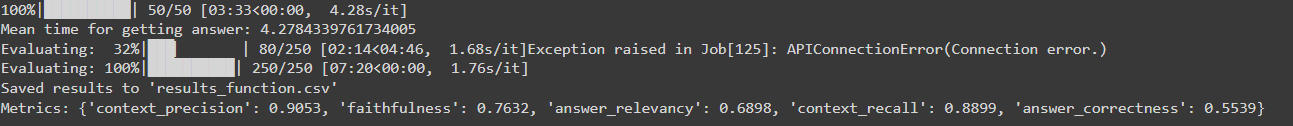

## Valid on case test_data

In [ ]:
class Test_Evaluator:
    """
    Class for evaluating pipeline on test set.
    """
    def __init__(self, test_set_path: str):
        self.raw_test_data = pd.read_excel(test_set_path).drop(columns=['evolution_type'])
        self.test_data = self.raw_test_data
        print(f"Test data size {self.test_data.shape}")

    async def evaluate_pipe(self, pipeline) -> None:
        """
        Evaluate pipeline on test set.
        """
        answers = []
        contexts = []
        times = []
        for item in tqdm(self.test_data['question'].values):
            start_time = time.time()
            result = await pipeline.predict(item)
            end_time = time.time()
            answers.append(result['answer'])
            contexts.append(result['context'][:2])
            times.append(end_time - start_time)

        mean_time = sum(times) / len(times)
        print(f"Mean time for getting answer: {mean_time}")

        test_answers = self.test_data
        test_answers['answer'] = answers
        test_answers['contexts'] = contexts
        test_answers.to_csv("test_answers_context.csv")

In [ ]:
evaler = Test_Evaluator("test_npa_itmo.xlsx")

Test data size (100, 1)


In [ ]:
await evaler.evaluate_pipe(pipeline)

100%|██████████| 100/100 [1:21:34<00:00, 48.94s/it]

Mean time for getting answer: 48.93863652467728
